There are a few potential stumbling blocks before beginning. PyTorch MPS requires MacOS 12.3 or later and an ARM Python installation.
This can be checked by using the platform module:

In [69]:
import platform
platform.platform()

'macOS-12.3-arm64-arm-64bit'

Next it can be installed:
```python
# MPS acceleration is available on MacOS 12.3+
pip3 install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu
```
- torch: https://download.pytorch.org/whl/nightly/cpu/torch-1.13.0.dev20220701-cp39-none-macosx_11_0_arm64.whl

- torchvision: https://download.pytorch.org/whl/nightly/cpu/torchvision-0.14.0.dev20220701-cp39-cp39-macosx_11_0_arm64.whl

- torchaudio: https://download.pytorch.org/whl/nightly/cpu/torchaudio-0.14.0.dev20220603-cp39-cp39-macosx_11_0_arm64.whl

In [70]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import torchvision
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torchvision.models as models
import time
import numpy as np
from torchvision import datasets, transforms
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

Next we confirm that our torch installation has access to MPS/Metal:

In [71]:
torch.has_mps

True

In [72]:
CPU= False
device = "cpu" if CPU else torch.device("mps")
print("Device is :: {}".format(device))

Device is :: mps


In [73]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [74]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args['dry_run']:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [75]:
torch.cuda.is_available()

False

In [76]:
train_kwargs = {'batch_size': 128, 'num_workers': 10, 'shuffle': True}
test_kwargs = {'batch_size': 128, 'num_workers': 10, 'shuffle': True}

In [77]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [78]:
dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                    transform=transform)

In [79]:
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

In [80]:
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=1.0)

In [81]:
args = {'log_interval': 10, 'dry_run': False}

In [82]:
## GPU

In [83]:
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
#set time
start = time.time()
for epoch in range(1, 5 + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()
gpu_time = time.time() - start
print("Time taken: {}".format(gpu_time))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304453
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.268060
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.657003
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.373205
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.557102
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.366653
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.247815
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.187772
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.497210
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.285228
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.273993
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.218646
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.090166
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.124340
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.241153
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.071774
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.208764
Train Epoch: 1 [21760/60000 (36%)]	Loss: 0.299683
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.148412
Train Epoch: 1 [24320/60000 (41%)]	Loss: 0.142137
Train Epoch: 1 [

In [84]:
CPU= True
device = "cpu" if CPU else torch.device("mps")
print("Device is :: {}".format(device))

Device is :: cpu


In [85]:
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=1.0)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
#set time
start = time.time()
for epoch in range(1, 5 + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()
cpu_time = time.time() - start
print("Time taken: {}".format(cpu_time))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.310045
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.560467
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.766729
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.588063
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.454216
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.402699
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.276324
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.285399
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.274607
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.207322
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.172833
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.175990
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.248890
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.258125
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.235406
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.180931
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.073137
Train Epoch: 1 [21760/60000 (36%)]	Loss: 0.247340
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.084198
Train Epoch: 1 [24320/60000 (41%)]	Loss: 0.112842
Train Epoch: 1 [

In [86]:
#bar graph with time taken
import matplotlib.pyplot as plt
import numpy as np

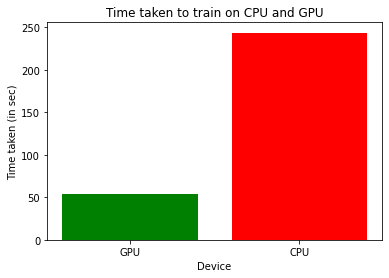

In [87]:
plt.bar(['GPU', 'CPU'], [gpu_time, cpu_time], color=['green', 'red'])
plt.xlabel('Device')
plt.ylabel('Time taken (in sec)')
plt.title('Time taken to train on CPU and GPU')
plt.show()